### Homework 8: CPL likelihood 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
arr_hub = np.loadtxt('Hz_all.dat')
z_obs= arr_hub[:,0]
hub_obs = arr_hub[:,1]
error_obs = arr_hub[:,2]

In [4]:

# cosmological parameters :
H0 = 70
Om = 0.3
Or = 1e-4
Ol = 1.0 - Om - Or

# parametrization 
def w_CPL(z, w0, wa):
    return w0 + wa * (z / (1 + z))
# Hubble with the CPL parametrization
def Hubble_CPL(z, w0, wa):
    w_z = w_CPL(z, w0, wa)
    exponent = 3 * (1 + w0 + wa) * np.log(1 + z) - 3 * wa * (z / (1 + z))
    return H0 * np.sqrt(Om * (1 + z)**3 + Or * (1 + z)**4 + Ol * np.exp(exponent))


Best-fit parameters: w0 = -1.2030, wa = 0.6636


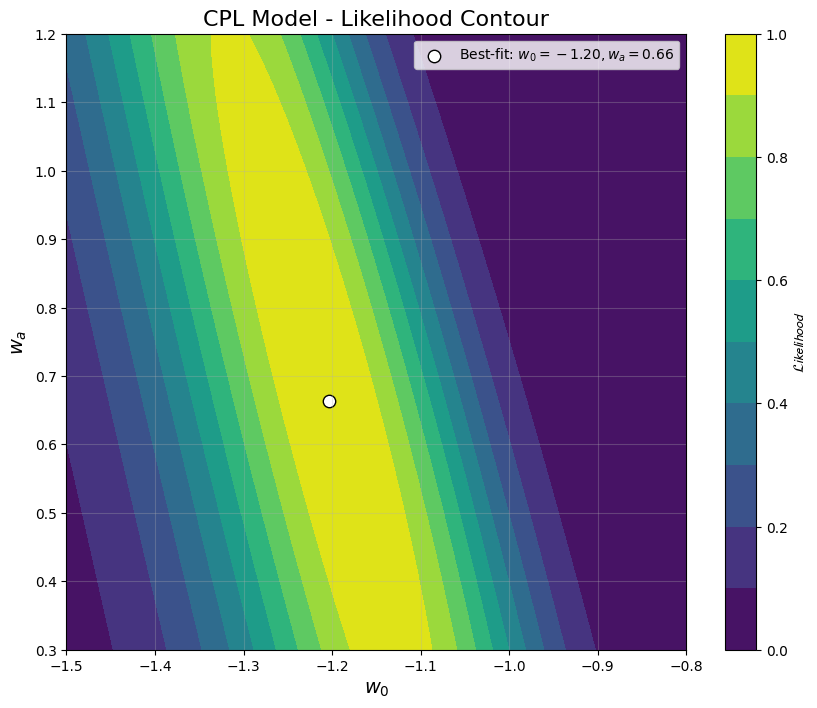

In [5]:
# Define chi-squared function
def chi_squared(w0, wa, z_obs, hub_obs, error_obs, Hubble_CPL):
    H_theory = np.array([Hubble_CPL(z, w0, wa) for z in z_obs])
    return np.sum(((hub_obs - H_theory) / error_obs) ** 2)

# Define log-likelihood function 
def log_likelihood(w0, wa, z_obs, hub_obs, error_obs, Hubble_CPL):
    chi2 = chi_squared(w0, wa, z_obs, hub_obs, error_obs, Hubble_CPL)
    return -0.5 * chi2

# Define parameter space
w0_vals = np.linspace(-1.5, -0.8, 100)
wa_vals = np.linspace(0.3, 1.2, 100)
W0, Wa = np.meshgrid(w0_vals, wa_vals)

# Compute log-likelihood using vectorized operations
log_L = np.array([[log_likelihood(w0, wa, z_obs, hub_obs, error_obs, Hubble_CPL) 
                    for w0 in w0_vals] for wa in wa_vals])

# Convert log-likelihood to likelihood for plotting
L = np.exp(log_L - np.max(log_L))  # Normalize for better numerical stability

#best-fit parameters
max_index = np.unravel_index(np.argmax(L), L.shape)
w0_best, wa_best = W0[max_index], Wa[max_index]
print(f"Best-fit parameters: w0 = {w0_best:.4f}, wa = {wa_best:.4f}")

# Plot contour map
plt.figure(figsize=(10, 8))
contour = plt.contourf(W0, Wa, L, levels=10, cmap='viridis')
plt.colorbar(contour, label='$\mathcal{Likelihood}$')
plt.scatter(w0_best, wa_best, color='white', edgecolor='black', marker='o', s=80, 
            label=f'Best-fit: $w_0={w0_best:.2f}, w_a={wa_best:.2f}$')

# Labels and title
plt.xlabel('$w_0$', fontsize=14)
plt.ylabel('$w_a$', fontsize=14)
plt.title('CPL Model - Likelihood Contour', fontsize=16)
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [17]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import random
from scipy.stats import chi2 as chi2_dist  # Renamed to avoid conflict


In [19]:
# Create grid and select 100 random combinations
W0, Wa = np.meshgrid(w0_vals, wa_vals)
all_combinations = list(zip(W0.flatten(), Wa.flatten()))
random_combinations = random.sample(all_combinations, 100)

# Calculate chi-squared for each combination and sort by likelihood
scored_combinations = [(w0, wa, chi_squared(w0, wa)) for (w0, wa) in random_combinations]
scored_combinations.sort(key=lambda x: x[2])  # Sort by chi-squared (ascending)


In [27]:

# Prepare for animation
z_vals = np.linspace(0, 2.5, 100)
fig, ax = plt.subplots(figsize=(10, 6))
line, = ax.plot([], [], 'r-', lw=2)
current_params = ax.text(0.05, 0.95, '', transform=ax.transAxes, fontsize=12,
                        bbox=dict(facecolor='white', alpha=0.8))


ax.errorbar(z_obs, hub_obs, yerr=error_obs, fmt='o', markersize=5, color='darkblue', alpha=0.7, label='CC Data')
ax.set_xlabel('$z$', fontsize=12)
ax.set_ylabel('$H(z)$', fontsize=12)
ax.set_title('CPL Model Animation (Sorted by Likelihood)', fontsize=14)
ax.legend(loc='lower right')
ax.set_xlim(0, 2.0)
ax.set_ylim(40, 200)
ax.grid()

def init():
    line.set_data([], [])
    current_params.set_text('')
    return line, current_params

def update(frame):
    w0, wa, current_chi2 = scored_combinations[frame]  # Renamed variable here
    H_vals = [Hubble_CPL(z, w0, wa) for z in z_vals]
    line.set_data(z_vals, H_vals)
    
    dof = len(z_obs) - 2  
    p_value = 1 - chi2_dist.cdf(current_chi2, dof)  
    
    current_params.set_text(f'$w_0$ = {w0:.2f} $w_a$ = {wa:.2f}')
    return line, current_params


ani = FuncAnimation(fig, update, frames=len(scored_combinations),
                    init_func=init, blit=True, interval=300)


plt.tight_layout()
plt.close()  
HTML(ani.to_html5_video())  

In [16]:
# Print best 5 combinations
print("Top 5 most likely combinations:")
for i, (w0, wa, current_chi2) in enumerate(scored_combinations[:5], 1):
    dof = len(z_obs) - 2
    p_value = 1 - chi2_dist.cdf(current_chi2, dof)  # Using the renamed chi2_dist
    print(f"{i}. w_0 = {w0:.3f}, w_a = {wa:.3f} (chi^2/DoF = {current_chi2/dof:.1f}, p = {p_value:.3f})")

Top 5 most likely combinations:
1. w_0 = -1.203, w_a = 0.636 (chi^2/DoF = 0.6, p = 0.942)
2. w_0 = -1.189, w_a = 0.691 (chi^2/DoF = 0.6, p = 0.941)
3. w_0 = -1.168, w_a = 0.455 (chi^2/DoF = 0.6, p = 0.941)
4. w_0 = -1.260, w_a = 0.973 (chi^2/DoF = 0.6, p = 0.940)
5. w_0 = -1.231, w_a = 0.600 (chi^2/DoF = 0.6, p = 0.939)
